In [186]:
import torch
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os
from scipy.fft import dctn, idctn

import matplotlib.pyplot as plt

In [165]:
download_path = os.path.join(os.getcwd(), 'cifar10')

if not os.path.exists(download_path):
    os.makedirs(download_path)

In [166]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = CIFAR10(download_path, transform=transform, download=True)

Files already downloaded and verified


In [167]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [168]:
rgb_image = train_dataset[0][0]

In [169]:
def rgb_to_ycbcr(image: torch.Tensor) -> torch.Tensor:
    r"""Convert an RGB image to YCbCr.

    Args:
        image (torch.Tensor): RGB Image to be converted to YCbCr.

    Returns:
        torch.Tensor: YCbCr version of the image.
    """

    if not torch.is_tensor(image):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(image)))

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError("Input size must have a shape of (*, 3, H, W). Got {}"
                         .format(image.shape))

    r: torch.Tensor = image[..., 0, :, :]
    g: torch.Tensor = image[..., 1, :, :]
    b: torch.Tensor = image[..., 2, :, :]

    delta = .5
    y: torch.Tensor = .299 * r + .587 * g + .114 * b
    cb: torch.Tensor = -0.168736 * r - 0.331264 * g + .5 * b + 128
    cr: torch.Tensor = .5 * r - .418688 * g - .081312 * b + 128
    return torch.stack((y, cb, cr), -3)

In [170]:
def ycbcr_to_rgb(image: torch.Tensor) -> torch.Tensor:

    r"""Convert an YCbCr image to RGB.

     Args:
         image (torch.Tensor): YCbCr Image to be converted to RGB.

     Returns:
         torch.Tensor: RGB version of the image.
     """

    if not torch.is_tensor(image):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(image)))

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError("Input size must have a shape of (*, 3, H, W). Got {}"
                         .format(image.shape))

    Y: torch.Tensor = image[..., 0, :, :]
    Cb: torch.Tensor = image[..., 1, :, :] - 128
    Cr: torch.Tensor = image[..., 2, :, :] - 128

    R: torch.Tensor = Y + 1.40210 * Cr
    G: torch.Tensor = Y - 0.34414 * Cb - .71414 * Cr
    B: torch.Tensor = Y + 1.7718 * Cb
    return torch.stack((R, G, B), -3)

In [171]:
ycbcr_image = rgb_to_ycbcr(rgb_image * 255)

In [172]:
first_patch = ycbcr_image[..., :, 0:8, 0:8]
luminance_patch = first_patch[0, :, :]

In [173]:
dct_luminance_patch = torch.zeros(*luminance_patch.shape)

In [174]:
def _patch_to_dct(luminance: torch.Tensor) -> torch.Tensor:
    pi = torch.tensor(torch.pi)

    dct_luminance_patch = torch.zeros(*luminance.shape)

    for u in range(0, 8):
        for v in range(0,8):
            Cu = torch.sqrt(torch.tensor(0.5)) if u == 0 else torch.tensor(1)
            Cv = torch.sqrt(torch.tensor(0.5)) if v == 0 else torch.tensor(1)

            values = torch.zeros(8,8)
            for x in range(0, 8):
                for y in range(0, 8):
                    u_, v_, x_, y_ = torch.tensor(u), torch.tensor(v), torch.tensor(x), torch.tensor(y)
                    cosine = torch.cos(((2*x_+1)*u_*pi)/16)*torch.cos(((2*y_+1)*v_*pi)/16)
                    values[x, y] = luminance_patch[x, y] * cosine

            dct_luminance_patch[u, v] = 0.25 * Cu * Cv * torch.sum(values)

    return dct_luminance_patch

In [177]:
def quantize_luminance(dct: torch.Tensor, alpha: int = 1) -> torch.Tensor:
    luminance_quantization_matrix = torch.tensor([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])

    luminance_quantization_matrix *= alpha

    return torch.round(torch.div(dct, luminance_quantization_matrix)).to(torch.int8)

In [187]:
def compute_dct(image_patch):
    # Convert from PyTorch tensor to NumPy array if necessary
    if isinstance(image_patch, torch.Tensor):
        image_patch = image_patch.numpy()

    # Apply DCT in both dimensions using dctn for n-dimensional DCT
    dct_2d = dctn(image_patch, norm='ortho')

    # Convert back to PyTorch tensor from NumPy array
    return torch.from_numpy(dct_2d)

In [202]:
def blockwise_dct(image, block_size=(8, 8)):
    # Get the image dimensions
    image = image.numpy()
    height, width = image.shape
    block_height, block_width = block_size

    # Prepare an array to hold the DCT coefficients
    dct_blocks = np.zeros_like(image, dtype=np.float32)

    # Process each block
    for i in range(0, height, block_height):
        for j in range(0, width, block_width):
            # Extract the block from the image
            block = image[i:i+block_height, j:j+block_width]

            # Apply the 2D DCT to the block
            dct_block = dctn(block, norm='ortho')

            # Store the DCT coefficients
            dct_blocks[i:i+block_height, j:j+block_width] = dct_block

    return torch.from_numpy(dct_blocks)

In [218]:
def blockwise_quantize_luminance(dct: torch.Tensor, mode = 'l', alpha: int = 1, block_size = (8, 8)) -> torch.Tensor:
    luminance_quantization_matrix = torch.tensor([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])

    chrominance_quantization_matrix = torch.tensor([
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99]
    ])

    quantization_matrix = luminance_quantization_matrix if mode == 'l' else chrominance_quantization_matrix


    height, width = dct.shape
    block_height, block_width = block_size


    quantization_matrix *= alpha

    quantisation_blocks = torch.zeros((height, width), dtype=torch.float32)

    for i in range(0, height, block_height):
        for j in range(0, width, block_width):
            # Extract the block from the image
            block = dct[i:i+block_height, j:j+block_width]

            quantised_block = torch.round(torch.div(block, quantization_matrix)).to(torch.int8)

            # Apply the 2D DCT to the block
            quantisation_blocks[i:i+block_height, j:j+block_width] = quantised_block

    return quantisation_blocks

In [217]:
dct_values = blockwise_dct(ycbcr_image[0])
blockwise_quantize_luminance(dct_values)

[[ 5.8491406e+02 -1.4517218e+02 -3.5958576e+01 ... -6.1379242e-01
  -9.7064314e+00 -1.6535378e+00]
 [-8.7408714e+01 -8.6338623e+01  3.0270355e+01 ...  4.4978607e-02
   6.7314968e+00 -6.9103813e-01]
 [ 4.6285728e+01  1.2139616e+01  4.3125526e+01 ... -5.4089403e+00
  -3.0684109e+00  4.6020260e+00]
 ...
 [-1.3754064e+01  3.1450195e+00 -9.0244884e+00 ... -6.6093922e+00
   1.8308866e+00  1.0422053e+00]
 [ 1.2474425e+01  1.1125956e+01  3.3378935e+00 ... -2.2370701e+00
   3.3754075e-01 -9.3675220e-01]
 [-1.5882726e+00 -2.0529487e+00  3.2460651e+00 ... -1.8913083e+00
   2.9359870e+00 -2.5503957e-01]]


tensor([[ 37., -13.,  -4.,  ...,   0.,   0.,   0.],
        [ -7.,  -7.,   2.,  ...,   0.,   0.,   0.],
        [  3.,   1.,   3.,  ...,   0.,   0.,   0.],
        ...,
        [ -1.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.]])

In [188]:
dct = compute_dct(luminance_patch)
dct_2 = _patch_to_dct(luminance_patch)
print(quantize_luminance(dct))
print(quantize_luminance(dct_2))

tensor([[ 37, -13,  -4,   1,   0,   0,   0,   0],
        [ -7,  -7,   2,   1,   0,   0,   0,   0],
        [  3,   1,   3,   0,   0,   0,   0,   0],
        [  2,   1,   0,   0,   0,   0,   0,   0],
        [  1,   1,   0,   0,   0,   0,   0,   0],
        [  1,   1,   0,   0,   0,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]], dtype=torch.int8)
tensor([[ 37, -13,  -4,   1,   0,   0,   0,   0],
        [ -7,  -7,   2,   1,   0,   0,   0,   0],
        [  3,   1,   3,   0,   0,   0,   0,   0],
        [  2,   1,   0,   0,   0,   0,   0,   0],
        [  1,   1,   0,   0,   0,   0,   0,   0],
        [  1,   1,   0,   0,   0,   0,   0,   0],
        [  1,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]], dtype=torch.int8)


# Checking the code

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


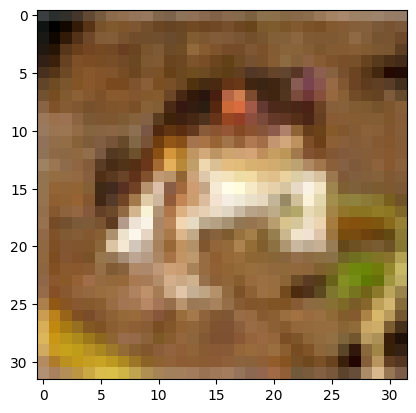

In [15]:
recover = ycbcr_to_rgb(rgb_to_ycbcr(rgb_image*255))
plt.imshow(recover.permute(1, 2, 0) / 255)
plt.show()

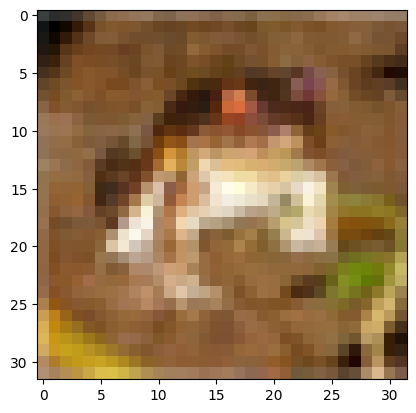

In [16]:
plt.imshow(rgb_image.permute(1, 2, 0))
plt.show()